Erkennung von Distribution Shifts mithilfe des Kolmogorov-Smirnov-Test 


Comparing Dataset A and Dataset B for Weight: Week 2, p-value: 0.0333


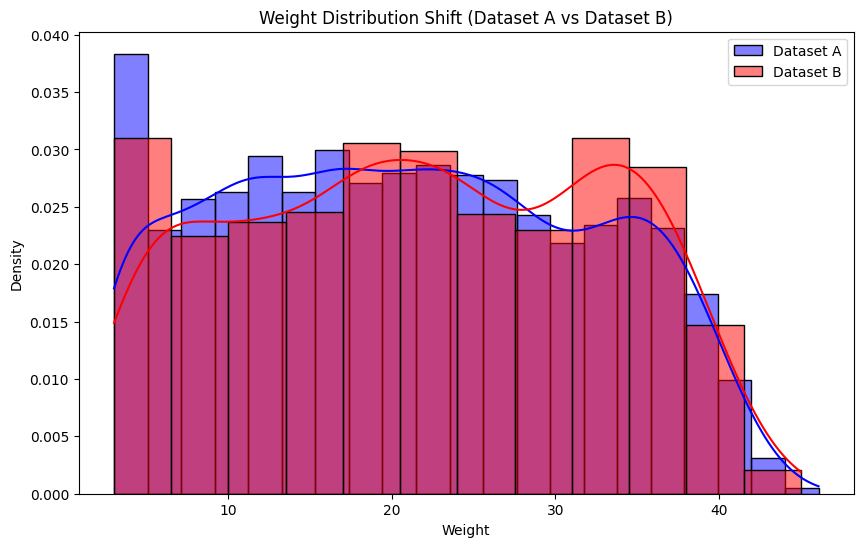


Comparing Dataset A and Dataset B for Connection: Week 0, p-value: 0.0000


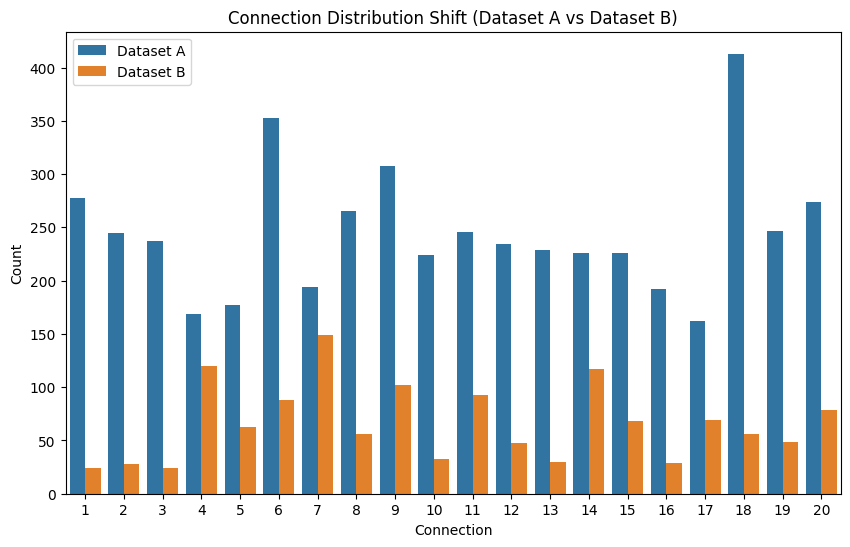


Comparing Dataset A and Dataset B for Connection: Week 1, p-value: 0.0000


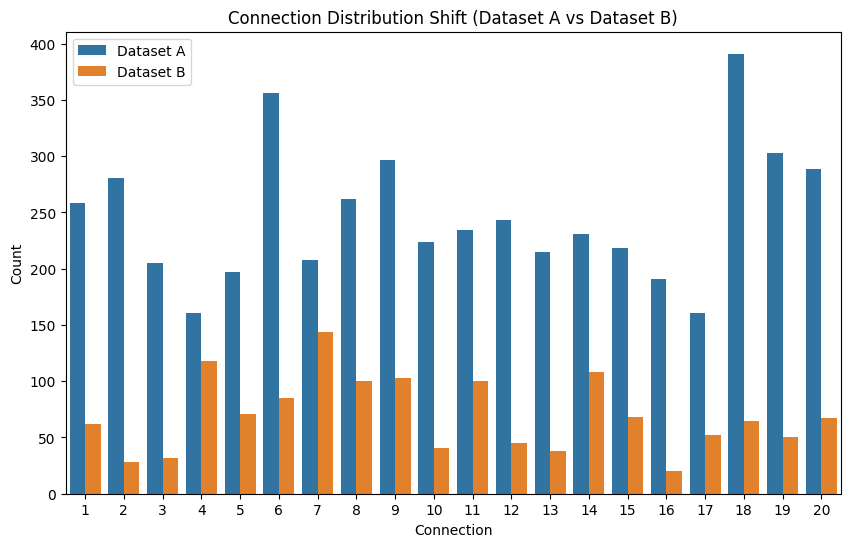


Comparing Dataset A and Dataset B for Connection: Week 2, p-value: 0.0000


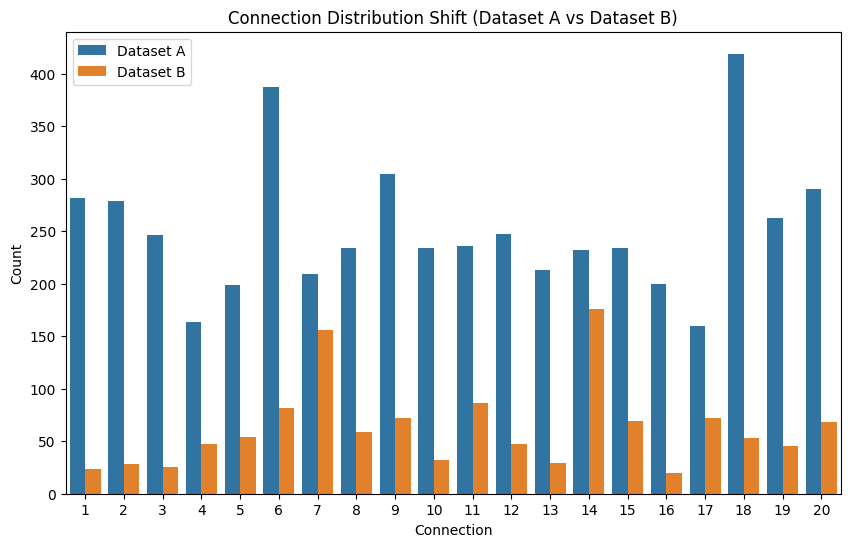


Comparing Dataset A and Dataset B for Connection: Week 3, p-value: 0.0000


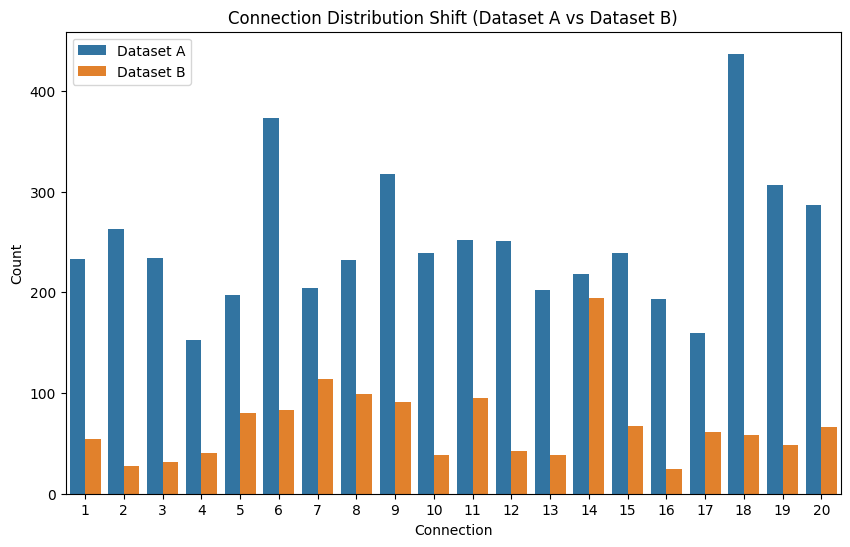


Comparing Dataset A and Dataset B for Unit_type: Week 0, p-value: 0.0000


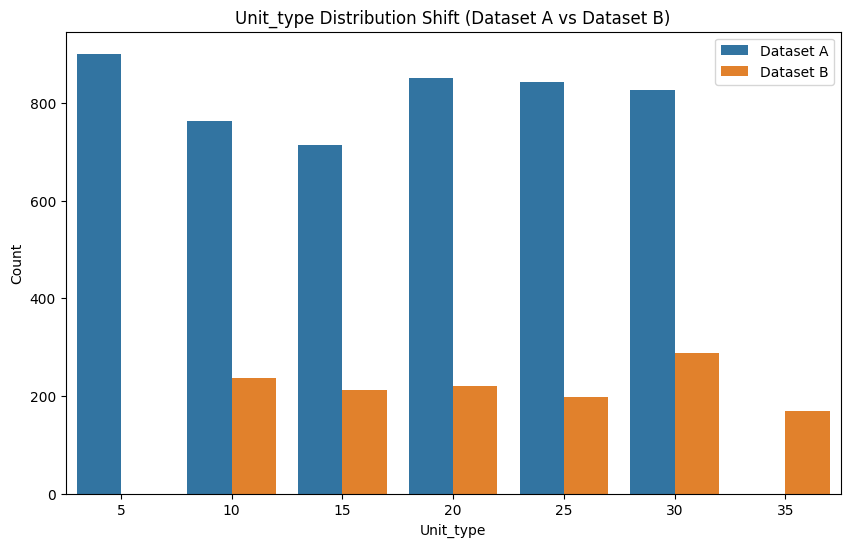


Comparing Dataset A and Dataset B for Unit_type: Week 1, p-value: 0.0000


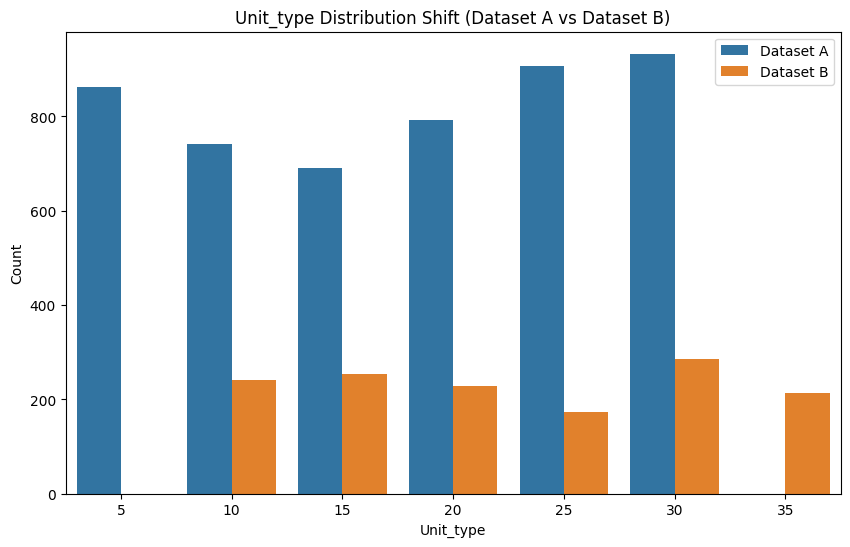


Comparing Dataset A and Dataset B for Unit_type: Week 2, p-value: 0.0000


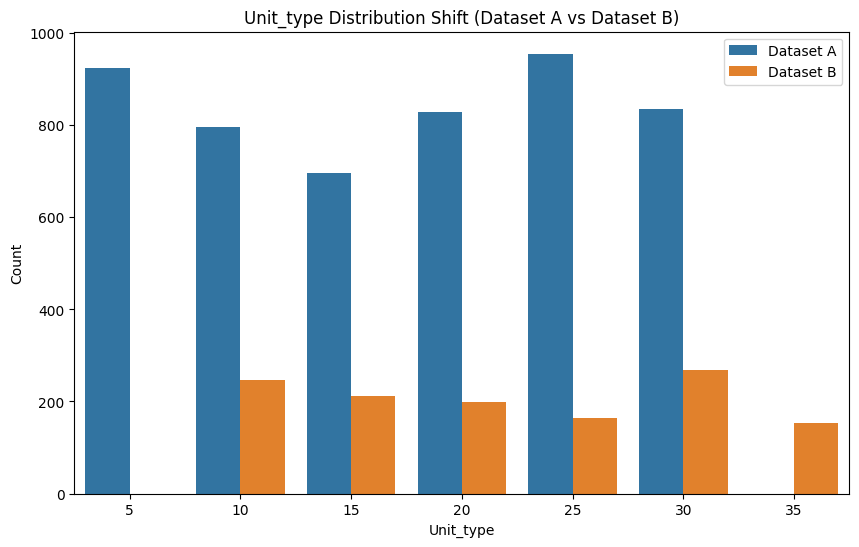


Comparing Dataset A and Dataset B for Unit_type: Week 3, p-value: 0.0000


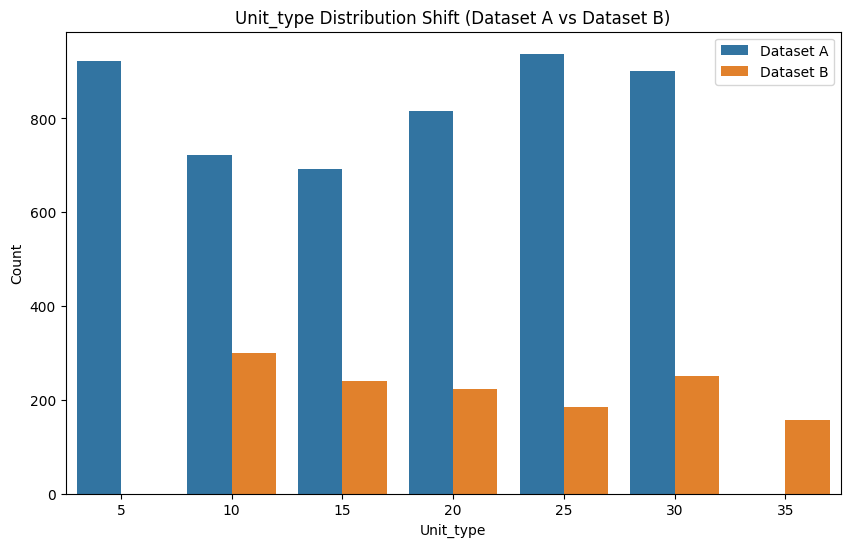

,C_max,K,V_max,lambd,sim_weeks,UT_list
0,20,98,30,0.012433,4,"[5, 10, 15, 20, 25, 30]"


,C_max,K,V_max,lambd,sim_weeks,UT_list
0,20,89,50,0.100809,4,"[10, 15, 20, 25, 30, 35]"



Significant shifts detected:
      Feature  Week        p_value
0      Weight     2   3.325606e-02
1  Connection     0   1.211842e-67
2  Connection     1   3.221018e-52
3  Connection     2   9.790378e-79
4  Connection     3   2.487682e-64
5   Unit_type     0  3.057694e-189
6   Unit_type     1  3.165820e-221
7   Unit_type     2  1.356607e-191
8   Unit_type     3  3.177780e-189


In [10]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy.stats import ks_2samp, chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns

# Load the datasets
file_path_a = '/Users/ericduhme/Documents/UNI/PAMI/PAMI_Projekt/Output Customer Data/customer_profile_0.csv'  # Adjust this path to your first CSV file location
file_path_b = '/Users/ericduhme/Documents/UNI/PAMI/PAMI_Projekt/Output Customer Data/customer_profile_1.csv'  # Adjust this path to your second CSV file location

data_a = pd.read_csv(file_path_a)
data_b = pd.read_csv(file_path_b)

# Load parameter values
params_file = '/Users/ericduhme/Documents/UNI/PAMI/PAMI_Projekt/Output Customer Data/params.csv'  # Adjust this path to your parameters CSV file location
params_df = pd.read_csv(params_file)

# Get parameter values for the datasets
param_a = params_df[params_df['Dataset'] == 0].iloc[0]
param_b = params_df[params_df['Dataset'] == 1].iloc[0]

# Create DataFrames for the parameters
params_a_df = pd.DataFrame([param_a], columns=params_df.columns)
params_b_df = pd.DataFrame([param_b], columns=params_df.columns)
params_a_df.set_index('Dataset', inplace=True)
params_b_df.set_index('Dataset', inplace=True)
params_a_df = params_a_df.reset_index(drop=True)
params_b_df = params_b_df.reset_index(drop=True)
# Function to detect distribution shift for continuous variables using KS test
def detect_continuous_shifts(data_a, data_b, feature, alpha=0.05):
    weeks = sorted(data_a['Week'].unique())
    significant_shifts = []
    
    for week in weeks:
        week_a = data_a[data_a['Week'] == week][feature]
        week_b = data_b[data_b['Week'] == week][feature]
        
        # Perform KS test
        if not week_a.empty and not week_b.empty:
            ks_stat, p_value = ks_2samp(week_a, week_b)
            
            # Check if the shift is significant
            if p_value < alpha:
                significant_shifts.append((feature, week, p_value))
    
    return significant_shifts

# Function to detect significant differences for discrete variables using Chi-Square test
def detect_discrete_shifts(data_a, data_b, feature, alpha=0.05):
    weeks = sorted(data_a['Week'].unique())
    significant_shifts = []
    
    for week in weeks:
        week_a = data_a[data_a['Week'] == week][feature].value_counts()
        week_b = data_b[data_b['Week'] == week][feature].value_counts()
        
        # Align the series to ensure they have the same categories
        week_a, week_b = week_a.align(week_b, fill_value=0)
        
        # Create a contingency table
        contingency_table = pd.DataFrame([week_a, week_b])
        
        # Perform Chi-Square test
        chi2_stat, p_value, dof, ex = chi2_contingency(contingency_table)
        
        # Check if the difference is significant
        if p_value < alpha:
            significant_shifts.append((feature, week, p_value))
    
    return significant_shifts

# Detect shifts for each feature
features_continuous = ['Weight']
features_discrete = ['Connection', 'Unit_type']
all_significant_shifts = []

for feature in features_continuous:
    shifts = detect_continuous_shifts(data_a, data_b, feature)
    all_significant_shifts.extend(shifts)
for feature in features_discrete:
    shifts = detect_discrete_shifts(data_a, data_b, feature)
    all_significant_shifts.extend(shifts)

# Create a DataFrame for significant shifts
columns = ['Feature', 'Week', 'p_value']
significant_shifts_df = pd.DataFrame(all_significant_shifts, columns=columns)

# Output the significant shifts and visualize
for feature in significant_shifts_df['Feature'].unique():
    feature_shifts = significant_shifts_df[significant_shifts_df['Feature'] == feature]
    for _, row in feature_shifts.iterrows():
        week = row['Week']
        p_value = row['p_value']
        
        print(f"\nComparing Dataset A and Dataset B for {feature}: Week {week}, p-value: {p_value:.4f}")
        
        # Visualize the shifts
        week_a_data = data_a[data_a['Week'] == week][feature]
        week_b_data = data_b[data_b['Week'] == week][feature]
        
        plt.figure(figsize=(10, 6))
        if feature in features_continuous:
            sns.histplot(week_a_data, color='blue', label='Dataset A', kde=True, stat="density")
            sns.histplot(week_b_data, color='red', label='Dataset B', kde=True, stat="density")
            plt.xlabel(feature)
        else:
            # Create DataFrame for plotting
            week_a_df = week_a_data.value_counts().reset_index()
            week_a_df.columns = [feature, 'Count']
            week_a_df['Dataset'] = 'Dataset A'
            
            week_b_df = week_b_data.value_counts().reset_index()
            week_b_df.columns = [feature, 'Count']
            week_b_df['Dataset'] = 'Dataset B'
            
            plot_df = pd.concat([week_a_df, week_b_df])
            
            sns.barplot(x=feature, y='Count', hue='Dataset', data=plot_df)
            plt.xlabel(feature)
            plt.ylabel('Count')
        
        plt.title(f'{feature} Distribution Shift (Dataset A vs Dataset B)')
        plt.ylabel('Density' if feature in features_continuous else 'Count')
        plt.legend()
        plt.show()

# Display parameter values
display(params_a_df)
display(params_b_df)

# Display the DataFrame with significant shifts
print("\nSignificant shifts detected between Week A and Week B:")
display(significant_shifts_df)